In [ ]:
# whole code using random forest clasifier

In [ ]:
import os
import pandas as pd

!pip install hvplot
import hvplot.pandas

from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#define spark version
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done


In [ ]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Demographics").getOrCreate()

In [ ]:
#Read in the data from the group github repo
from pyspark import SparkFiles
url = "https://raw.githubusercontent.com/AlexFeeney/Project4_Group3/main/Data/healthcare-dataset-stroke-data.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("healthcare-dataset-stroke-data.csv"), sep=",", header=True)

# Show DataFrame
df.show()

+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male| 67|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female| 61|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male| 80|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female| 49|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female| 79|           1|            0|         Yes|Self

In [ ]:
#convert to pandas df
pandas_df = df.toPandas()


#check pandas df
pandas_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked,1
2,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24,never smoked,1


In [ ]:
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline

In [ ]:
df_stroke=pandas_df
#df_stroke.head()

In [ ]:
df_stroke["gender"].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [ ]:
df_stroke["ever_married"].value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

In [ ]:
# NO TO BE 0 AND YES IS 1 IN EVER_MARRIED COLUMN

def ever_married(x):
    if x=="Yes":
        return 1
    else:
        return 0

df_stroke["ever_married"]=df_stroke["ever_married"].map(ever_married)
df_stroke

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67,0,1,1,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61,0,0,1,Self-employed,Rural,202.21,N/A,never smoked,1
2,31112,Male,80,0,1,1,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49,0,0,1,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79,1,0,1,Self-employed,Rural,174.12,24,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80,1,0,1,Private,Urban,83.75,N/A,never smoked,0
5106,44873,Female,81,0,0,1,Self-employed,Urban,125.2,40,never smoked,0
5107,19723,Female,35,0,0,1,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51,0,0,1,Private,Rural,166.29,25.6,formerly smoked,0


In [ ]:
df_stroke["work_type"].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [ ]:
df_stroke["Residence_type"].value_counts()

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

In [ ]:
#1= urban, 0=rural
def Residence_type(x):
    if x=="Urban":
        return 1
    else:
        return 0

df_stroke["Residence_type"]=df_stroke["Residence_type"].map(Residence_type)
df_stroke

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,51676,Female,61,0,0,1,Self-employed,0,202.21,N/A,never smoked,1
2,31112,Male,80,0,1,1,Private,0,105.92,32.5,never smoked,1
3,60182,Female,49,0,0,1,Private,1,171.23,34.4,smokes,1
4,1665,Female,79,1,0,1,Self-employed,0,174.12,24,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80,1,0,1,Private,1,83.75,N/A,never smoked,0
5106,44873,Female,81,0,0,1,Self-employed,1,125.2,40,never smoked,0
5107,19723,Female,35,0,0,1,Self-employed,0,82.99,30.6,never smoked,0
5108,37544,Male,51,0,0,1,Private,0,166.29,25.6,formerly smoked,0


In [ ]:

df_stroke=df_stroke.drop(columns=["id"])
df_dummies=pd.get_dummies(df_stroke)
df_dummies


,ever_married,Residence_type,gender_Female,gender_Male,gender_Other,age_0.08,age_0.16,age_0.24,age_0.32,age_0.4,...,bmi_78,bmi_92,bmi_97.6,bmi_N/A,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke_0,stroke_1
0,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,1,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
5106,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
5107,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
5108,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [ ]:

# df_dummies is your DataFrame containing dummy variables


# Extracting binary target variable
y = df_dummies["stroke_1"]
 # Assuming stroke_1 represents the positive class

# Dropping unnecessary columns from the feature matrix
X = df_dummies.drop(columns=["stroke_1"])

# Display the first few rows of the binary target variable
print(y.head())


0    1
1    1
2    1
3    1
4    1
Name: stroke_1, dtype: uint8


In [ ]:
X.head()

,ever_married,Residence_type,gender_Female,gender_Male,gender_Other,age_0.08,age_0.16,age_0.24,age_0.32,age_0.4,...,bmi_71.9,bmi_78,bmi_92,bmi_97.6,bmi_N/A,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke_0
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# importing a scaling modeule
from sklearn.preprocessing import StandardScaler

# Since the numeric attributes in the dataset is in different ranges and three are outliers persent we are usign a scaler to get all the values into the same range.
scaler = StandardScaler()
# Scaling the numeric attributes
X_scaler = scaler.fit(X_train)
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
#df_dummies[['bmi', 'avg_glucose_level', 'age']] = scaler.fit_transform(df_dummies[['bmi', 'avg_glucose_level', 'age']])

# Making Predictions Using The Random Forest model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, mean_squared_error

# Assuming y and X are defined somewhere in your code
# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate a SimpleImputer to impute missing values with the mean
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transform both training and testing data
X_train_imputed = imputer.fit_transform(X_train_scaled)
X_test_imputed = imputer.transform(X_test_scaled)

# Create a RandomForestClassifier instance
rf_classifier = RandomForestClassifier(n_estimators=500, random_state=78)

# Train the classifier on the imputed training data
rf_classifier.fit(X_train_imputed, y_train)

# Predict on the imputed testing data
y_pred = rf_classifier.predict(X_test_imputed)

# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)
print("Confusion Matrix:\n", cm_df)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate precision, recall, and F1-score on the training data
y_train_pred = rf_classifier.predict(X_train_imputed)
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)
print ("USING X_train")
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Confusion Matrix:
           Predicted 0  Predicted 1
Actual 0          960            0
Actual 1            0           62
Accuracy: 1.0
Mean Squared Error: 0.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       960
           1       1.00      1.00      1.00        62

    accuracy                           1.00      1022
   macro avg       1.00      1.00      1.00      1022
weighted avg       1.00      1.00      1.00      1022

USING X_train
Precision: 1.0
Recall: 1.0
F1-score: 1.0


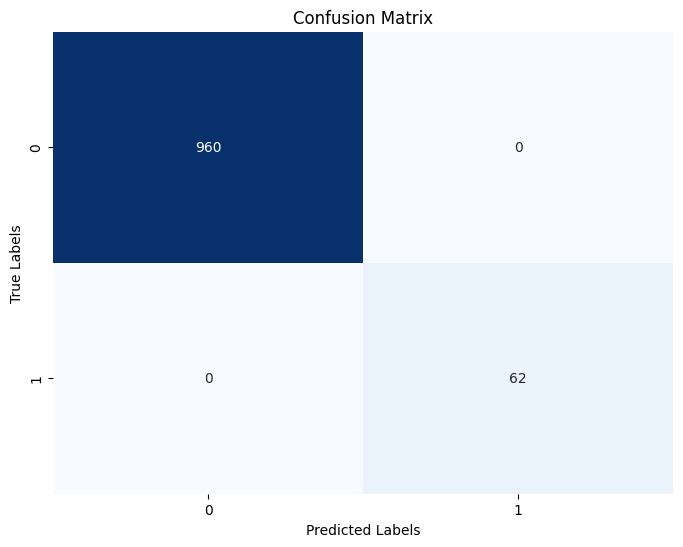

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



# Feature Importance

In [ ]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_classifier.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_classifier.feature_importances_, X.columns), reverse=True)

[(0.4540255595013435, 'stroke_0'),
 (0.009613794117318981, 'bmi_N/A'),
 (0.008481727537306824, 'Residence_type'),
 (0.007260006442270035, 'work_type_Private'),
 (0.006893613672579428, 'smoking_status_never smoked'),
 (0.006190798694301787, 'heart_disease_1'),
 (0.006135823704268239, 'work_type_Self-employed'),
 (0.0057279401021042686, 'hypertension_1'),
 (0.005705607668861748, 'smoking_status_formerly smoked'),
 (0.005632439027177177, 'heart_disease_0'),
 (0.005631259391095657, 'hypertension_0'),
 (0.005624622256106634, 'smoking_status_smokes'),
 (0.005601580658793063, 'ever_married'),
 (0.00555703250380969, 'smoking_status_Unknown'),
 (0.005116736522074062, 'age_81'),
 (0.004552986593822665, 'age_78'),
 (0.004045853806231676, 'work_type_Govt_job'),
 (0.003906813365441558, 'age_79'),
 (0.003389376410480683, 'avg_glucose_level_101.45'),
 (0.0030666943303201133, 'age_80'),
 (0.002757507068587968, 'age_76'),
 (0.0025915549541869927, 'age_68'),
 (0.002528906092621291, 'bmi_36.5'),
 (0.0024

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

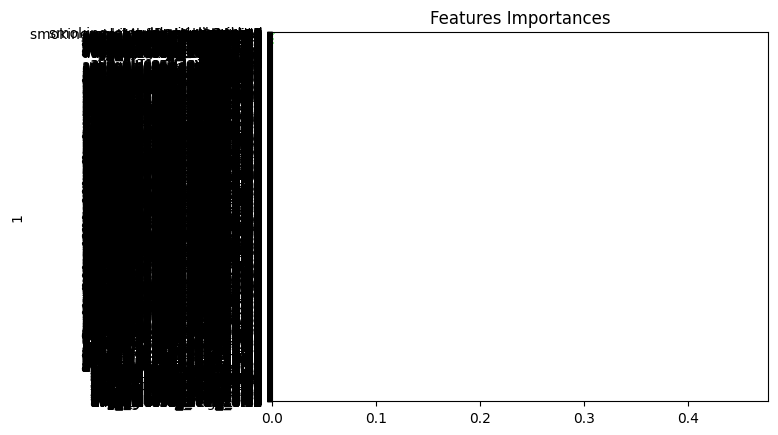

In [ ]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip( rf_classifier.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)